In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "CAMTA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn001091,MEVEIVSTETIKPSSPTPIHLKTFSLSLLDQLNAPVFSKLVYFYPH...,1485,1
1,Achn048091,MAESRRYGLGTQLDIEQILLEAQHRWLRPAEICEILRNFKKFRIAP...,1075,1
2,Achn059301,MLRNFRKDGHNWKKKKDGKTVKEAHEHLKNLDYEDDGNSRTLEHIV...,724,1
3,Achn102611,MAPGRSDVKSPEHGTPIVEEDFVVDGVDRLGIGSSSNEEEDGVQVT...,1220,1
4,Achn103241,MENIVPGRLEGWEIHGFRTMEDLDFGNILEEAKARWLRPNEIHAML...,757,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2362,0.029451,0.000000,0.002677,0.004016,0.004016,0.006693,0.001339,0.002677,0.001339,0.004016,...,0.001339,0.001339,0.001339,0.002677,0.001339,0.001339,0.000000,0.000000,0.0,0.002677
951,0.004604,0.002762,0.004604,0.006446,0.000921,0.001842,0.004604,0.002762,0.000000,0.006446,...,0.000000,0.000921,0.000000,0.003683,0.002762,0.001842,0.000921,0.000921,0.0,0.000921
274,0.014085,0.000000,0.007042,0.004024,0.002012,0.003018,0.002012,0.006036,0.006036,0.003018,...,0.001006,0.001006,0.004024,0.006036,0.001006,0.003018,0.000000,0.001006,0.0,0.003018
329,0.000000,0.000000,0.000000,0.031746,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873,...,0.000000,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2240,0.000000,0.003484,0.000000,0.010453,0.000000,0.000000,0.000000,0.000000,0.010453,0.006969,...,0.003484,0.003484,0.000000,0.000000,0.003484,0.003484,0.003484,0.000000,0.0,0.003484


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2127, 441)
X_test: (532, 441)
y_train: (2127,)
y_test: (532,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 13s 525ms/step - accuracy: 0.4531 - loss: 0.6932

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5505 - loss: 0.6882 - val_accuracy: 0.9648 - val_loss: 0.6315


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.6251

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9469 - loss: 0.5541 - val_accuracy: 0.9624 - val_loss: 0.2382


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.2502

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.1670 - val_accuracy: 0.9789 - val_loss: 0.0552


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0302

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0549 - val_accuracy: 0.9859 - val_loss: 0.0332


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0106

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0285 - val_accuracy: 0.9883 - val_loss: 0.0351


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0311

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0214 - val_accuracy: 0.9906 - val_loss: 0.0235


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0048

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0168 - val_accuracy: 0.9906 - val_loss: 0.0224


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0040

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0180 - val_accuracy: 0.9906 - val_loss: 0.0251


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0065

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0218 - val_accuracy: 0.9859 - val_loss: 0.0297


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0044

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0164 - val_accuracy: 0.9906 - val_loss: 0.0225


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0063

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0133 - val_accuracy: 0.9906 - val_loss: 0.0369


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0119

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.9859 - val_loss: 0.0222


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0011

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0038 - val_accuracy: 0.9883 - val_loss: 0.0237


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0023

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9883 - val_loss: 0.0356


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6427e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0051 - val_accuracy: 0.9906 - val_loss: 0.0337


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7833e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9906 - val_loss: 0.0289



[Train Accuracy: 99.65% - Test Accuracy: 99.06%]


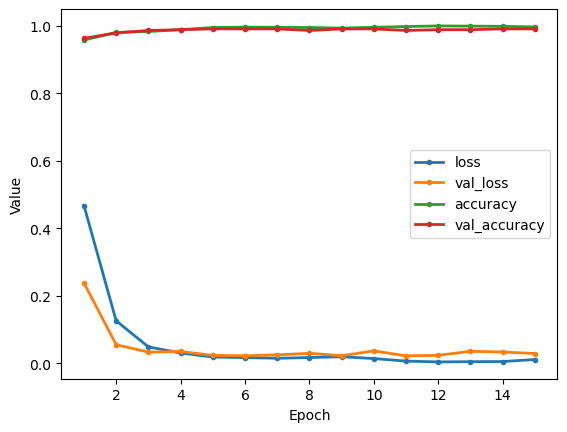

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2362,0.012064,0.0,0.000000,0.0,0.001340,0.0,0.00134,0.001340,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
951,0.000922,0.0,0.000922,0.0,0.000000,0.0,0.00000,0.000922,0.0,0.000922,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
274,0.003021,0.0,0.002014,0.0,0.001007,0.0,0.00000,0.001007,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.001007,0.0,0.0,0.0,0.0
329,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2240,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2127, 8589)
X_test: (532, 8589)
y_train: (2127,)
y_test: (532,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,199,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,242,305 (8.55 MB)

 Trainable params: 2,242,305 (8.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - accuracy: 0.3594 - loss: 0.6932

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4514 - loss: 0.6929   

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4765 - loss: 0.6911

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4970 - loss: 0.6879 - val_accuracy: 0.9836 - val_loss: 0.6153


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.6089

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9716 - loss: 0.5886 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9746 - loss: 0.5527

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9778 - loss: 0.5093 - val_accuracy: 0.9859 - val_loss: 0.0900


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0891

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9901 - loss: 0.0742 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9906 - loss: 0.0612

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9913 - loss: 0.0524 - val_accuracy: 0.9883 - val_loss: 0.0259


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0053

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0065 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0062

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9930 - val_loss: 0.0209


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0051

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0029 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0026

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0024 - val_accuracy: 0.9906 - val_loss: 0.0215


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.7118e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6192e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6937e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1219e-04 - val_accuracy: 0.9883 - val_loss: 0.0276


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0016

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4085e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5281e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9026e-04 - val_accuracy: 0.9906 - val_loss: 0.0203


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.7361e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7831e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3470e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.1933e-04 - val_accuracy: 0.9906 - val_loss: 0.0158


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.2406e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4823e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3550e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9480e-04 - val_accuracy: 0.9930 - val_loss: 0.0163


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.0423e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2025e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1916e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0837e-04 - val_accuracy: 0.9906 - val_loss: 0.0194


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.2786e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0834e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2529e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3055e-04 - val_accuracy: 0.9883 - val_loss: 0.0243


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.5145e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6794e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4198e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3158e-04 - val_accuracy: 0.9906 - val_loss: 0.0209


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.7461e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2270e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2262e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1731e-04 - val_accuracy: 0.9906 - val_loss: 0.0143


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.5367e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6068e-05 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0940e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6628e-05 - val_accuracy: 0.9906 - val_loss: 0.0216



[Train Accuracy: 100.00% - Test Accuracy: 99.06%]


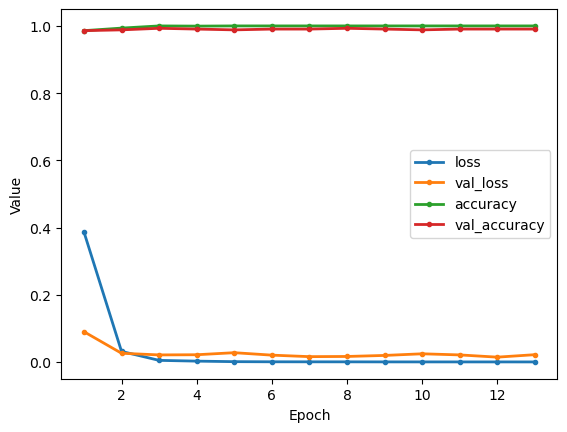

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
2362,0.005369,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,0.001008,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2240,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,357,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,398,273 (127.40 MB)

 Trainable params: 33,398,273 (127.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 17s 661ms/step - accuracy: 0.4062 - loss: 0.6932

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4258 - loss: 0.6932  

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4245 - loss: 0.6933

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4297 - loss: 0.6933

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4400 - loss: 0.6933

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4483 - loss: 0.6933

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4544 - loss: 0.6932

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4598 - loss: 0.6932

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4649 - loss: 0.6931

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4723 - loss: 0.6931

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4796 - loss: 0.6930

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4874 - loss: 0.6929

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4957 - loss: 0.6928

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5035 - loss: 0.6927

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5103 - loss: 0.6926

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5166 - loss: 0.6925

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5232 - loss: 0.6923

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5300 - loss: 0.6922

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5369 - loss: 0.6920

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5438 - loss: 0.6918

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5506 - loss: 0.6916

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5573 - loss: 0.6914

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5640 - loss: 0.6912

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5706 - loss: 0.6909

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5770 - loss: 0.6906

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5833 - loss: 0.6903

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5893 - loss: 0.6900

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5949 - loss: 0.6897 - val_accuracy: 0.9695 - val_loss: 0.6370


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9844 - loss: 0.6330

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9844 - loss: 0.6312 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9792 - loss: 0.6303

 4/27 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9756 - loss: 0.6286

 5/27 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9748 - loss: 0.6266

 6/27 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9751 - loss: 0.6245

 7/27 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9755 - loss: 0.6223

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9759 - loss: 0.6200

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9762 - loss: 0.6174

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9764 - loss: 0.6148 

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9765 - loss: 0.6121

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9767 - loss: 0.6092

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9769 - loss: 0.6063

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9770 - loss: 0.6033

15/27 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9772 - loss: 0.6001

16/27 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9774 - loss: 0.5968

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9776 - loss: 0.5933

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9777 - loss: 0.5897

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9779 - loss: 0.5859

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9781 - loss: 0.5820

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9782 - loss: 0.5781

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9783 - loss: 0.5740

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9783 - loss: 0.5698

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9784 - loss: 0.5655

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9785 - loss: 0.5612

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9787 - loss: 0.5568

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9787 - loss: 0.5524

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9788 - loss: 0.5484 - val_accuracy: 0.9836 - val_loss: 0.1585


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 1.0000 - loss: 0.1318

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.1285

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.1240

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.1191

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.1150

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9996 - loss: 0.1121

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9993 - loss: 0.1092

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9992 - loss: 0.1061

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9991 - loss: 0.1030

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9990 - loss: 0.1002

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9988 - loss: 0.0977

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9986 - loss: 0.0956

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9984 - loss: 0.0935

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9982 - loss: 0.0915

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9981 - loss: 0.0896

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9979 - loss: 0.0878

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9978 - loss: 0.0860

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9977 - loss: 0.0844

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9975 - loss: 0.0828

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9974 - loss: 0.0814

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9973 - loss: 0.0799

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9973 - loss: 0.0785

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9972 - loss: 0.0772

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9972 - loss: 0.0759

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9971 - loss: 0.0747

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9971 - loss: 0.0735

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9971 - loss: 0.0724

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9970 - loss: 0.0713 - val_accuracy: 0.9859 - val_loss: 0.0400


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9844 - loss: 0.0169

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9883 - loss: 0.0162

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9905 - loss: 0.0149

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9919 - loss: 0.0136

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9929 - loss: 0.0131

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9936 - loss: 0.0125

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9942 - loss: 0.0120

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9947 - loss: 0.0115

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9951 - loss: 0.0111

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9954 - loss: 0.0107

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9957 - loss: 0.0103

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9960 - loss: 0.0100

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9962 - loss: 0.0097

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9964 - loss: 0.0094

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9965 - loss: 0.0091

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9967 - loss: 0.0089

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9968 - loss: 0.0087

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9970 - loss: 0.0085

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9971 - loss: 0.0084

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9972 - loss: 0.0082

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9973 - loss: 0.0080

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9974 - loss: 0.0079

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9975 - loss: 0.0078

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9975 - loss: 0.0076

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9976 - loss: 0.0075

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9977 - loss: 0.0074

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9977 - loss: 0.0073

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.9859 - val_loss: 0.0337


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0012

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0013

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0013

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0013

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0013

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0013

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0013

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0014

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0014

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0015

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0015

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0015

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0015

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0015

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9859 - val_loss: 0.0387


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 7.3478e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.0699e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.1396e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.1391e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.2342e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2671e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.2958e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2754e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2430e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2402e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2856e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2939e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.3080e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.3182e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.3582e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.3859e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4148e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4353e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4517e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4631e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4779e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4938e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.5061e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.5157e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.5313e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.5424e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.5535e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 7.5637e-04 - val_accuracy: 0.9859 - val_loss: 0.0422


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 5.4498e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.4856e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.3740e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.2656e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.2003e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2024e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2206e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.3317e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.4313e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.4788e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.5001e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.4984e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4831e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4878e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4908e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4829e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4719e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4563e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4381e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4208e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4255e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4231e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4179e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.4087e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3981e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3856e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 5.3721e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 5.3595e-04 - val_accuracy: 0.9859 - val_loss: 0.0451


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 3.5334e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.2091e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.6360e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.7144e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.6653e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.6116e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.5479e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.2191e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.7284e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.0739e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.3133e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.4875e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.6052e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7181e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.7941e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.8487e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.8958e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.9252e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.0150e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.0875e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.1437e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 6.1879e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 6.2177e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 6.2370e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 6.2470e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 6.2512e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 6.2509e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 6.2506e-04 - val_accuracy: 0.9859 - val_loss: 0.0432


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 2.6466e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.5219e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.3975e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.5930e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.7398e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.7914e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.8105e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.8243e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.8704e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.9059e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.9308e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.9448e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.9483e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.9502e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.9565e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.9540e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.9514e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9470e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9397e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9312e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9233e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9152e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9055e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9055e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9047e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9030e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.9006e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 2.8983e-04 - val_accuracy: 0.9859 - val_loss: 0.0484


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 3.3287e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.9992e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.7440e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.5924e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.4916e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 1.0000 - loss: 2.4073e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 2.3467e-04 

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 2.2877e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 2.2362e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 2.1957e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 2.1589e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 2.1263e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 2.0949e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 2.0667e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 2.0533e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 2.0404e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 2.0269e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 2.0146e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 2.0020e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 1.9895e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 1.9792e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 1.9693e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 1.9597e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 1.9537e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.9480e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.9420e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9358e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 1.9300e-04 - val_accuracy: 0.9859 - val_loss: 0.0517


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 7.3860e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.0285e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1939e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.2239e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.2372e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.2760e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.3013e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.3214e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.3360e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.4616e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.5554e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.6229e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.6765e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.7212e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.7560e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.7833e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8032e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8218e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8370e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8481e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8558e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8614e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8646e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8663e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8669e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8667e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.8664e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 1.8660e-04 - val_accuracy: 0.9859 - val_loss: 0.0452


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 3.5782e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.8667e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 2.5053e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.3384e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.2474e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.1768e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.1021e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.0400e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.9952e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.9495e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.9100e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.8716e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.8435e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.8198e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.8050e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.7937e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.7819e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7697e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7576e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7451e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7320e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.7193e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.7068e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.6948e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.6831e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.6719e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.6611e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 1.6510e-04 - val_accuracy: 0.9859 - val_loss: 0.0499


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 7.6045e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 8.5854e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 8.9788e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.7639e-05

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0005e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.0259e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0656e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0885e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1017e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1067e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1089e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1092e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1076e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1042e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1049e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1035e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1018e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0987e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0953e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0915e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0894e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0963e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1016e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1054e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1085e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1107e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1125e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.1142e-04 - val_accuracy: 0.9859 - val_loss: 0.0527



[Train Accuracy: 100.00% - Test Accuracy: 99.25%]


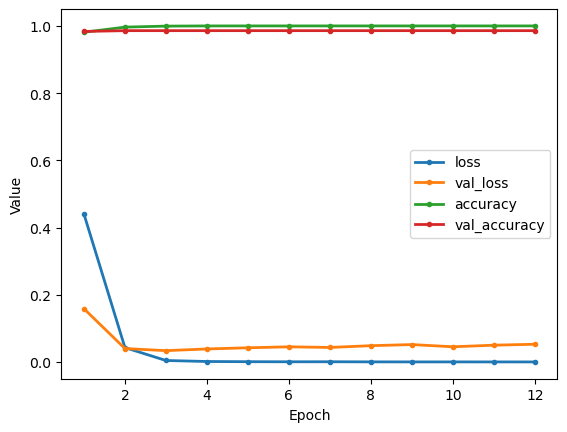

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/CAMTA/report_7C1YZ8T2.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################